In [17]:
!pip install pandas

!pip install matplotlib
!pip install openpyxl


In [18]:

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import tensorflow.compat.v1 as tf
import pandas as pd
import matplotlib.pyplot as plt

Epoch 1/5000, Loss: 78.8872
Epoch 50/5000, Loss: 3.7258
Epoch 100/5000, Loss: 0.8274
Epoch 150/5000, Loss: 0.2560
Epoch 200/5000, Loss: 0.1013
Epoch 250/5000, Loss: 0.0463
Epoch 300/5000, Loss: 0.0221
Epoch 350/5000, Loss: 0.0149
Epoch 400/5000, Loss: 0.0070
Epoch 450/5000, Loss: 0.0519
Epoch 500/5000, Loss: 0.0072
Epoch 550/5000, Loss: 0.0043
Epoch 600/5000, Loss: 0.0129
Epoch 650/5000, Loss: 0.0020
Epoch 700/5000, Loss: 0.0006
Epoch 750/5000, Loss: 0.0776
Epoch 800/5000, Loss: 0.0004
Epoch 850/5000, Loss: 0.0002
Epoch 900/5000, Loss: 0.0006
Epoch 950/5000, Loss: 0.0207
Epoch 1000/5000, Loss: 0.0017
Epoch 1050/5000, Loss: 0.0011
Epoch 1100/5000, Loss: 0.0013
Epoch 1150/5000, Loss: 0.0598
Epoch 1200/5000, Loss: 0.0071
Epoch 1250/5000, Loss: 0.0018
Epoch 1300/5000, Loss: 0.0005
Epoch 1350/5000, Loss: 0.0045
Epoch 1400/5000, Loss: 0.0003
Epoch 1450/5000, Loss: 0.0035
Epoch 1500/5000, Loss: 0.0001
Epoch 1550/5000, Loss: 0.0070
Epoch 1600/5000, Loss: 0.0003
Epoch 1650/5000, Loss: 0.0348
Ep

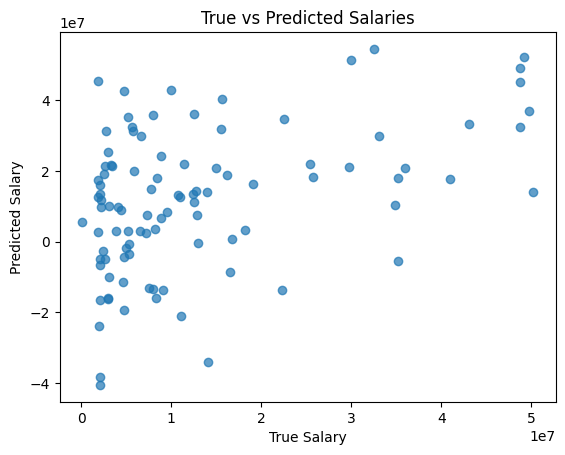

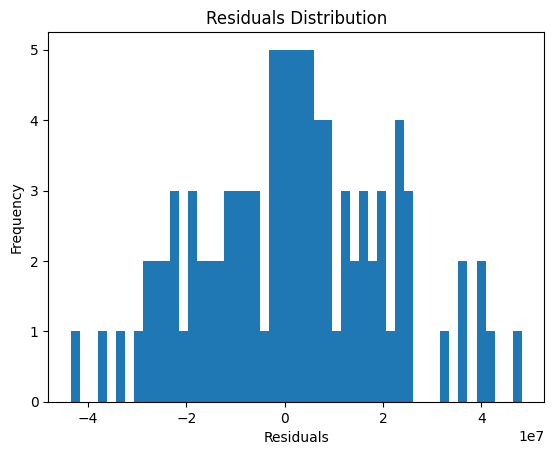

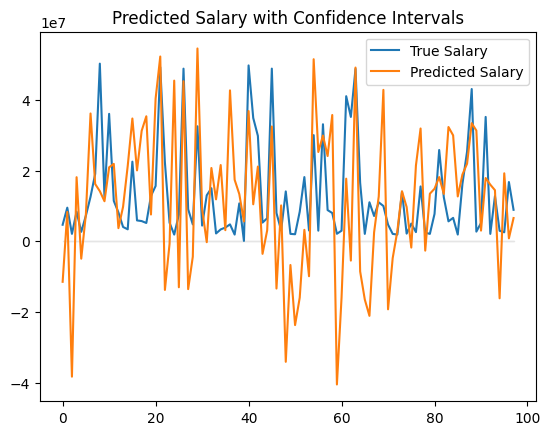

In [20]:
tf.disable_v2_behavior()

# Load data
training_data = pd.read_excel('RawData.xlsx', sheet_name='Training_Data')
test_data = pd.read_excel('RawData.xlsx', sheet_name='Test_Data')

# Prepare data
X_train = training_data[['Minutes', 'FG%', '3P%', 'FT%', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PPG', 'Age']].values
y_train = training_data['2024-25 Salary'].values.reshape(-1, 1)

X_test = test_data[['Minutes', 'FG%', '3P%', 'FT%', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PPG', 'Age']].values
y_test = test_data['2024-25 Salary'].values.reshape(-1, 1)

# Normalize data
X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

y_mean, y_std = y_train.mean(), y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

# PINN Model
class PINN:
    def __init__(self, input_dim, hidden_layers):
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.weights = []
        self.biases = []
        self._build_model()

    def _build_model(self):
        layers_dim = [self.input_dim] + self.hidden_layers + [1]
        for i in range(len(layers_dim) - 1):
            self.weights.append(tf.Variable(tf.random_normal([layers_dim[i], layers_dim[i + 1]])))
            self.biases.append(tf.Variable(tf.random_normal([layers_dim[i + 1]])))

    def forward(self, inputs):
        x = inputs
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            x = tf.tanh(tf.add(tf.matmul(x, w), b))
        return tf.add(tf.matmul(x, self.weights[-1]), self.biases[-1])

# Define the model
input_dim = X_train.shape[1]
hidden_layers = [64, 64, 64]  # Example larger network configuration
model = PINN(input_dim, hidden_layers)

# Placeholders for inputs and outputs
inputs = tf.placeholder(tf.float32, shape=(None, input_dim))
outputs = model.forward(inputs)
y_true = tf.placeholder(tf.float32, shape=(None, 1))

# Loss functions
def physics_loss(inputs, outputs):
    """Physics loss: Ensure positive relationships between specific variables."""
    gradients = tf.gradients(outputs, inputs)[0]
    grad_minutes = gradients[:, 0]  # Minutes
    grad_fg = gradients[:, 1]  # FG%
    grad_ppg = gradients[:, 9]  # PPG

    # Positive relationship constraints
    minutes_constraint = tf.reduce_mean(tf.square(tf.maximum(-grad_minutes, 0)))
    fg_constraint = tf.reduce_mean(tf.square(tf.maximum(-grad_fg, 0)))
    ppg_constraint = tf.reduce_mean(tf.square(tf.maximum(-grad_ppg, 0)))

    return minutes_constraint + fg_constraint + ppg_constraint

def boundary_loss(inputs):
    """Boundary condition: Limit salary increase for players above a certain age."""
    age = inputs[:, 10]  # Age is the 11th column
    gradients = tf.gradients(outputs, inputs)[0]
    salary_grad = gradients[:, 10]  # Derivative w.r.t Age
    penalty = tf.maximum(0.0, salary_grad - 0.05)  # Limit growth rate
    return tf.reduce_mean(tf.square(penalty))

data_loss = tf.reduce_mean(tf.square(y_true - outputs))  # MSE for predictions
physics_loss_term = physics_loss(inputs, outputs)
boundary_loss_term = boundary_loss(inputs)
total_loss = data_loss + 0.1 * physics_loss_term + 0.1 * boundary_loss_term

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(total_loss)

# Training loop
epochs = 5000
batch_size = 32

train_losses = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        epoch_loss = 0.0
        for i in range(0, X_train.shape[0], batch_size):
            batch_inputs = X_train[i:i + batch_size]
            batch_outputs = y_train[i:i + batch_size]
            _, loss_val = sess.run([optimizer, total_loss], feed_dict={inputs: batch_inputs, y_true: batch_outputs})
            epoch_loss += loss_val
        train_losses.append(epoch_loss / (X_train.shape[0] // batch_size))
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / (X_train.shape[0] // batch_size):.4f}")

    # Predict salaries on the test set
    y_test_pred = sess.run(outputs, feed_dict={inputs: X_test})
    mse_test = sess.run(tf.reduce_mean(tf.square(y_test_pred - y_test)))
    print(f"Test MSE: {mse_test:.4f}")




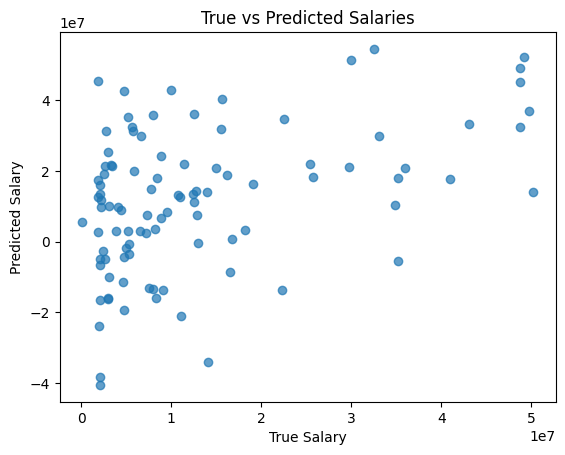

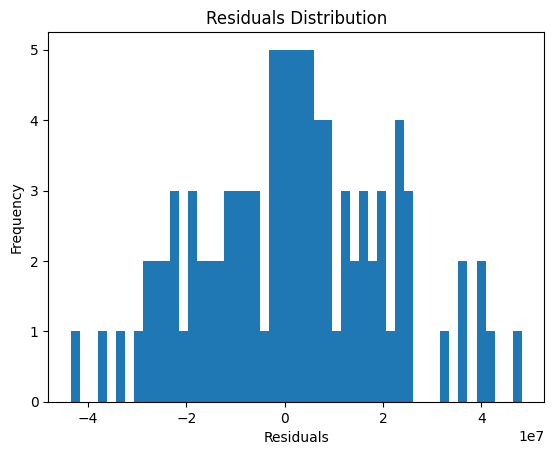

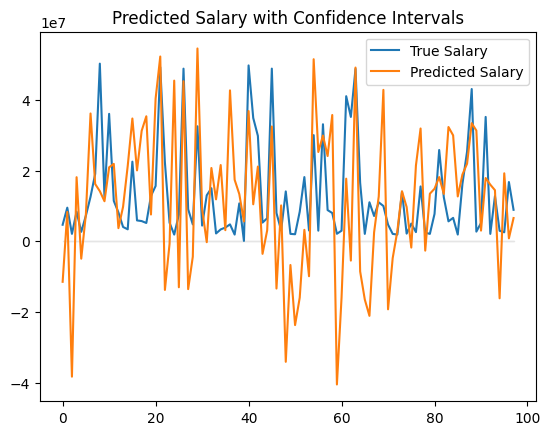

In [21]:
# Scatter plot of true vs predicted salaries
plt.scatter(y_test * y_std + y_mean, y_test_pred * y_std + y_mean, alpha=0.7)
plt.xlabel('True Salary')
plt.ylabel('Predicted Salary')
plt.title('True vs Predicted Salaries')
plt.show()

# Residual Analysis
residuals = (y_test * y_std + y_mean) - (y_test_pred * y_std + y_mean)
plt.hist(residuals, bins=50)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Confidence Intervals
lower_bound = y_test_pred - 1.96 * np.std(y_test_pred)
upper_bound = y_test_pred + 1.96 * np.std(y_test_pred)
plt.fill_between(range(len(y_test)), lower_bound.flatten(), upper_bound.flatten(), color='gray', alpha=0.2)
plt.plot(y_test * y_std + y_mean, label='True Salary')
plt.plot(y_test_pred * y_std + y_mean, label='Predicted Salary')
plt.legend()
plt.title('Predicted Salary with Confidence Intervals')
plt.show()

In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
import pandas as pd
import matplotlib.pyplot as plt

tf.disable_v2_behavior()

# Load data
training_data = pd.read_excel('RawData.xlsx', sheet_name='Training_Data')
test_data = pd.read_excel('RawData.xlsx', sheet_name='Test_Data')

# Prepare data
X_train = training_data[['Minutes', 'FG%', '3P%', 'FT%', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PPG', 'Age']].values
y_train = training_data['2024-25 Salary'].values.reshape(-1, 1)

X_test = test_data[['Minutes', 'FG%', '3P%', 'FT%', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PPG', 'Age']].values
y_test = test_data['2024-25 Salary'].values.reshape(-1, 1)

# Normalize data
X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

y_mean, y_std = y_train.mean(), y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

# PINN Model
class PINN:
    def __init__(self, input_dim, hidden_layers):
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.weights = []
        self.biases = []
        self._build_model()

    def _build_model(self):
        layers_dim = [self.input_dim] + self.hidden_layers + [1]
        for i in range(len(layers_dim) - 1):
            self.weights.append(tf.Variable(tf.random_normal([layers_dim[i], layers_dim[i + 1]])))
            self.biases.append(tf.Variable(tf.random_normal([layers_dim[i + 1]])))

    def forward(self, inputs):
        x = inputs
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            x = tf.tanh(tf.add(tf.matmul(x, w), b))
        return tf.add(tf.matmul(x, self.weights[-1]), self.biases[-1])

# Define the model
input_dim = X_train.shape[1]
hidden_layers = [64, 64, 64]
model = PINN(input_dim, hidden_layers)

# Placeholders for inputs and outputs
inputs = tf.placeholder(tf.float32, shape=(None, input_dim))
outputs = model.forward(inputs)
y_true = tf.placeholder(tf.float32, shape=(None, 1))

# Loss functions
def data_loss(outputs, y_true):
    return tf.reduce_mean(tf.square(y_true - outputs))  # MSE for predictions

def performance_loss(inputs, outputs):
    """Performance group loss: PPG, REB, AST, Minutes"""
    ppg = inputs[:, 9]    # PPG
    reb = inputs[:, 4]    # REB
    ast = inputs[:, 5]    # AST
    minutes = inputs[:, 0]  # Minutes
    salary_pred = outputs[:, 0]
    ppg_loss = tf.reduce_mean(tf.square(salary_pred - 0.5 * ppg))
    reb_loss = tf.reduce_mean(tf.square(salary_pred - 0.3 * reb))
    ast_loss = tf.reduce_mean(tf.square(salary_pred - 0.2 * ast))
    minutes_loss = tf.reduce_mean(tf.square(salary_pred - 0.1 * minutes))
    return ppg_loss + reb_loss + ast_loss + minutes_loss

def efficiency_loss(inputs, outputs):
    """Efficiency group loss: FG%, FT%, 3P%"""
    fg = inputs[:, 1]     # FG%
    ft = inputs[:, 3]     # FT%
    tp = inputs[:, 2]     # 3P%
    salary_pred = outputs[:, 0]
    fg_loss = tf.reduce_mean(tf.square(salary_pred - 0.4 * fg))
    ft_loss = tf.reduce_mean(tf.square(salary_pred - 0.2 * ft))
    tp_loss = tf.reduce_mean(tf.square(salary_pred - 0.3 * tp))
    return fg_loss + ft_loss + tp_loss

def nonlinear_interaction_loss(inputs, outputs):
    """Non-linear interaction loss"""
    salary_pred = outputs[:, 0]
    # REB × BLK
    reb_blk = inputs[:, 4] * inputs[:, 7]
    reb_blk_loss = tf.reduce_mean(tf.square(salary_pred - 0.5 * reb_blk))
    # PPG × Minutes
    ppg_minutes = inputs[:, 9] * inputs[:, 0]
    ppg_minutes_loss = tf.reduce_mean(tf.square(salary_pred - 0.3 * ppg_minutes))
    # AST × FG%
    ast_fg = inputs[:, 5] * inputs[:, 1]
    ast_fg_loss = tf.reduce_mean(tf.square(salary_pred - 0.2 * ast_fg))
    # 3P% × PPG
    tp_ppg = inputs[:, 2] * inputs[:, 9]
    tp_ppg_loss = tf.reduce_mean(tf.square(salary_pred - 0.4 * tp_ppg))
    return reb_blk_loss + ppg_minutes_loss + ast_fg_loss + tp_ppg_loss

def total_loss(inputs, outputs, y_true):
    data_loss_value = data_loss(outputs, y_true)
    perf_loss = performance_loss(inputs, outputs)
    eff_loss = efficiency_loss(inputs, outputs)
    nonlin_loss = nonlinear_interaction_loss(inputs, outputs)
    return (
        data_loss_value +
        0.1 * perf_loss +
        0.1 * eff_loss +
        0.05 * nonlin_loss
    )

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(total_loss(inputs, outputs, y_true))

# Training loop
epochs = 1000
batch_size = 256

train_losses = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        epoch_loss = 0.0
        for i in range(0, X_train.shape[0], batch_size):
            batch_inputs = X_train[i:i + batch_size]
            batch_outputs = y_train[i:i + batch_size]
            feed_dict = {inputs: batch_inputs, y_true: batch_outputs}
            _, loss_val = sess.run([train_step, total_loss(inputs, outputs, y_true)], feed_dict=feed_dict)
            epoch_loss += loss_val
        train_losses.append(epoch_loss / (X_train.shape[0] // batch_size))
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / (X_train.shape[0] // batch_size):.4f}")

    # Predict salaries on the test set
    y_test_pred = sess.run(outputs, feed_dict={inputs: X_test})
    mse_test = sess.run(tf.reduce_mean(tf.square(y_test_pred - y_test)))
    print(f"Test MSE: {mse_test:.6f}")

    # Save the model
    saver = tf.train.Saver()
    saver.save(sess, 'pinn_model_checkpoint')

# Scatter plot of true vs predicted salaries
plt.scatter(y_test * y_std + y_mean, y_test_pred * y_std + y_mean, alpha=0.7)
plt.xlabel('True Salary')
plt.ylabel('Predicted Salary')
plt.title('True vs Predicted Salaries')
plt.show()

# Residual Analysis
residuals = (y_test * y_std + y_mean) - (y_test_pred * y_std + y_mean)
plt.hist(residuals, bins=50)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Confidence Intervals
lower_bound = y_test_pred - 1.96 * np.std(y_test_pred)
upper_bound = y_test_pred + 1.96 * np.std(y_test_pred)
plt.fill_between(range(len(y_test)), lower_bound.flatten() * y_std + y_mean, upper_bound.flatten() * y_std + y_mean, color='gray', alpha=0.2)
plt.plot(y_test * y_std + y_mean, label='True Salary')
plt.plot(y_test_pred * y_std + y_mean, label='Predicted Salary')
plt.legend()
plt.title('Predicted Salary with Confidence Intervals')
plt.show()


Epoch 1/1000, Loss: 144.4157
Epoch 50/1000, Loss: 5.6227
Epoch 100/1000, Loss: 1.8198
Epoch 150/1000, Loss: 1.2513
Epoch 200/1000, Loss: 1.0985
Epoch 250/1000, Loss: 1.0474
Epoch 300/1000, Loss: 1.0255
Epoch 350/1000, Loss: 1.0134
Epoch 400/1000, Loss: 1.0090
Epoch 450/1000, Loss: 1.0067
Epoch 500/1000, Loss: 1.0053
Epoch 550/1000, Loss: 1.0043


In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
import pandas as pd
import matplotlib.pyplot as plt

tf.disable_v2_behavior()

# Load data
training_data = pd.read_excel('RawData.xlsx', sheet_name='Training_Data')
test_data = pd.read_excel('RawData.xlsx', sheet_name='Test_Data')

# Prepare data
X_train = training_data[['Minutes', 'FG%', '3P%', 'FT%', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PPG', 'Age']].values
y_train = training_data['2024-25 Salary'].values.reshape(-1, 1)

X_test = test_data[['Minutes', 'FG%', '3P%', 'FT%', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PPG', 'Age']].values
y_test = test_data['2024-25 Salary'].values.reshape(-1, 1)

# Normalize data
X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

y_mean, y_std = y_train.mean(), y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

# PINN Model
class PINN:
    def __init__(self, input_dim, hidden_layers):
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.weights = []
        self.biases = []
        self._build_model()

    def _build_model(self):
        layers_dim = [self.input_dim] + self.hidden_layers + [1]
        for i in range(len(layers_dim) - 1):
            self.weights.append(tf.Variable(tf.random_normal([layers_dim[i], layers_dim[i + 1]])))
            self.biases.append(tf.Variable(tf.random_normal([layers_dim[i + 1]])))

    def forward(self, inputs):
        x = inputs
        for w, b in zip(self.weights[:-1], self.biases[:-1]):
            x = tf.tanh(tf.add(tf.matmul(x, w), b))
        return tf.add(tf.matmul(x, self.weights[-1]), self.biases[-1])

# Define the model
input_dim = X_train.shape[1]
hidden_layers = [64, 64, 64]
model = PINN(input_dim, hidden_layers)

# Placeholders for inputs and outputs
inputs = tf.placeholder(tf.float32, shape=(None, input_dim))
outputs = model.forward(inputs)
y_true = tf.placeholder(tf.float32, shape=(None, 1))

# Loss functions
def data_loss(outputs, y_true):
    return tf.reduce_mean(tf.square(y_true - outputs))  # MSE for predictions

def performance_loss(inputs, outputs):
    ppg = inputs[:, 9]    # PPG
    reb = inputs[:, 4]    # REB
    ast = inputs[:, 5]    # AST
    minutes = inputs[:, 0]  # Minutes
    salary_pred = outputs[:, 0]
    ppg_loss = tf.reduce_mean(tf.square(salary_pred - 0.5 * ppg))
    reb_loss = tf.reduce_mean(tf.square(salary_pred - 0.3 * reb))
    ast_loss = tf.reduce_mean(tf.square(salary_pred - 0.2 * ast))
    minutes_loss = tf.reduce_mean(tf.square(salary_pred - 0.1 * minutes))
    return ppg_loss + reb_loss + ast_loss + minutes_loss

def efficiency_loss(inputs, outputs):
    fg = inputs[:, 1]     # FG%
    ft = inputs[:, 3]     # FT%
    tp = inputs[:, 2]     # 3P%
    salary_pred = outputs[:, 0]
    fg_loss = tf.reduce_mean(tf.square(salary_pred - 0.4 * fg))
    ft_loss = tf.reduce_mean(tf.square(salary_pred - 0.2 * ft))
    tp_loss = tf.reduce_mean(tf.square(salary_pred - 0.3 * tp))
    return fg_loss + ft_loss + tp_loss

def nonlinear_interaction_loss(inputs, outputs):
    salary_pred = outputs[:, 0]
    reb_blk = inputs[:, 4] * inputs[:, 7]  # REB × BLK
    ppg_minutes = inputs[:, 9] * inputs[:, 0]  # PPG × Minutes
    ast_fg = inputs[:, 5] * inputs[:, 1]  # AST × FG%
    tp_ppg = inputs[:, 2] * inputs[:, 9]  # 3P% × PPG
    reb_blk_loss = tf.reduce_mean(tf.square(salary_pred - 0.5 * reb_blk))
    ppg_minutes_loss = tf.reduce_mean(tf.square(salary_pred - 0.3 * ppg_minutes))
    ast_fg_loss = tf.reduce_mean(tf.square(salary_pred - 0.2 * ast_fg))
    tp_ppg_loss = tf.reduce_mean(tf.square(salary_pred - 0.4 * tp_ppg))
    return reb_blk_loss + ppg_minutes_loss + ast_fg_loss + tp_ppg_loss

def total_loss(inputs, outputs, y_true):
    data_loss_value = data_loss(outputs, y_true)
    perf_loss = performance_loss(inputs, outputs)
    eff_loss = efficiency_loss(inputs, outputs)
    nonlin_loss = nonlinear_interaction_loss(inputs, outputs)
    return (
        data_loss_value +
        0.1 * perf_loss +
        0.1 * eff_loss +
        0.05 * nonlin_loss
    )

# Optimizer with learning rate scheduler
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(
    learning_rate=0.001, global_step=global_step,
    decay_steps=100, decay_rate=0.96, staircase=True
)
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(total_loss(inputs, outputs, y_true), global_step=global_step)

# Early stopping settings
early_stop_threshold = 0.005  # 손실 변화 임계값
patience = 50  # 에포크 동안 변화 없으면 중단

# Training loop
epochs = 1000
batch_size = 256

train_losses = []
prev_loss = None
no_improvement_count = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        epoch_loss = 0.0
        for i in range(0, X_train.shape[0], batch_size):
            batch_inputs = X_train[i:i + batch_size]
            batch_outputs = y_train[i:i + batch_size]
            feed_dict = {inputs: batch_inputs, y_true: batch_outputs}
            _, loss_val = sess.run([train_step, total_loss(inputs, outputs, y_true)], feed_dict=feed_dict)
            epoch_loss += loss_val
        epoch_loss /= (X_train.shape[0] // batch_size)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.6f}")

        # Early Stopping Logic
        if prev_loss is not None and abs(prev_loss - epoch_loss) < early_stop_threshold:
            no_improvement_count += 1
        else:
            no_improvement_count = 0
        prev_loss = epoch_loss

        if no_improvement_count >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    # Predict salaries on the test set
    y_test_pred = sess.run(outputs, feed_dict={inputs: X_test})
    mse_test = sess.run(tf.reduce_mean(tf.square(y_test_pred - y_test)))
    print(f"Test MSE: {mse_test:.5f}")

    # Save the model
    saver = tf.train.Saver()
    saver.save(sess, 'pinn_model_checkpoint')

# Scatter plot of true vs predicted salaries
plt.scatter(y_test * y_std + y_mean, y_test_pred * y_std + y_mean, alpha=0.7)
plt.xlabel('True Salary')
plt.ylabel('Predicted Salary')
plt.title('True vs Predicted Salaries')
plt.show()

# Residual Analysis
residuals = (y_test * y_std + y_mean) - (y_test_pred * y_std + y_mean)
plt.hist(residuals, bins=50)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Confidence Intervals
lower_bound = y_test_pred - 1.96 * np.std(y_test_pred)
upper_bound = y_test_pred + 1.96 * np.std(y_test_pred)
plt.fill_between(range(len(y_test)), lower_bound.flatten() * y_std + y_mean, upper_bound.flatten() * y_std + y_mean, color='gray', alpha=0.2)
plt.plot(y_test * y_std + y_mean, label='True Salary')
plt.plot(y_test_pred * y_std + y_mean, label='Predicted Salary')
plt.legend()
plt.title('Predicted Salary with Confidence Intervals')
plt.show()


In [ ]:

tf.disable_v2_behavior()

# # Load data
# training_data = pd.read_excel('RawData.xlsx', sheet_name='Training_Data')
# test_data = pd.read_excel('RawData.xlsx', sheet_name='Test_Data')

# # Prepare data
# X_train = training_data[['Minutes', 'FG%', '3P%', 'FT%', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PPG', 'Age']].values
# y_train = training_data['Salary'].values.reshape(-1, 1)

# X_test = test_data[['Minutes', 'FG%', '3P%', 'FT%', 'REB', 'AST', 'STL', 'BLK', 'PF', 'PPG', 'Age']].values
# y_test = test_data['Salary'].values.reshape(-1, 1)

# Normalize data
X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

y_mean, y_std = y_train.mean(), y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

# Load the best model and evaluate
best_model_path = 'best_model_checkpoint'

with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, best_model_path)  # Load saved best model

    # Calculate train and test loss
    train_loss = sess.run(tf.reduce_mean(tf.square(y_train - sess.run(outputs, feed_dict={inputs: X_train}))))
    test_loss = sess.run(tf.reduce_mean(tf.square(y_test - sess.run(outputs, feed_dict={inputs: X_test}))))

    print(f"Final Train Loss: {train_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Visualize train vs test loss
    plt.plot(train_losses, label='Train Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train vs Test Loss')
    plt.legend()
    plt.show()

    # Predictions and residuals
    y_test_pred = sess.run(outputs, feed_dict={inputs: X_test})
    residuals = (y_test * y_std + y_mean) - (y_test_pred * y_std + y_mean)

    # Residuals histogram
    plt.hist(residuals, bins=50, color='blue', alpha=0.7)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # True vs Predicted Salaries
    plt.scatter(y_test * y_std + y_mean, y_test_pred * y_std + y_mean, alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Diagonal line
    plt.xlabel('True Salary')
    plt.ylabel('Predicted Salary')
    plt.title('True vs Predicted Salaries')
    plt.show()